In [15]:
#Prerequisite Libraries
import time
import pyvisa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

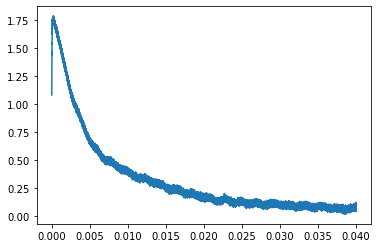

In [2]:
data = pd.read_csv('pi2_3_36.txt', header=None, names=["time", 'y1', 'y2'])
plt.plot(data.time, data.y1)

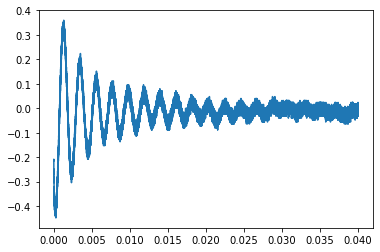

In [3]:
plt.plot(data.time, data.y2)

Text(0.5, 0, 'ms')

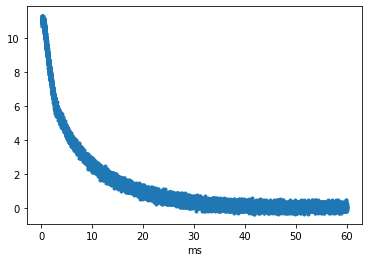

In [26]:
data = pd.read_csv('T2_star_3_27_2.txt', header=None, names=["time", 'amp'])
data.time *= 1000
start_i = data[data.amp == max(data.amp)].index[0]
end_i = data.index[data.time == 60][0]
plt.plot(data.time[start_i:end_i], data.amp[start_i:end_i], '.')
#plt.plot(data.time, data.amp, '.')
plt.xlabel('ms')

In [28]:
max(data.amp)

11.28

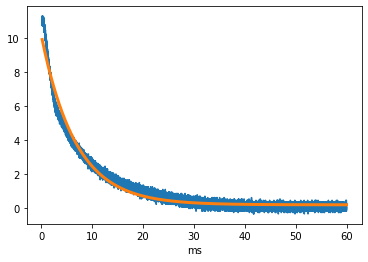

In [29]:


def exp_decay(t, A, decay, offset):
    return A*np.exp(-t/decay) + offset

fit, err = curve_fit(exp_decay, data.time[start_i:end_i], data.amp[start_i:end_i], p0 = [11.28, 2, 0])
plt.plot(data.time[start_i:end_i], data.amp[start_i:end_i])
plt.xlabel('ms')
plt.plot(data.time[start_i: end_i], exp_decay(data.time[start_i: end_i], *fit), linewidth = 3)
plt.show()


In [30]:
T2_star = fit[1]
T2_star_err = np.sqrt(err[1,1])
print('T2* time: %.2f +- %.1e ms' % (T2_star, T2_star_err))

T2* time: 6.75 +- 8.1e-03 ms


Sample Code for the NMR and Scope Control

The central libary for communication with the AWG and scope is pyvisa. This eis used to establish a connection to the device through which you can send a number of commands. The full list of commands can be found in the manuals for the AWG or scope.
In order to begin communication, we need the device address. 

In [2]:
AWG_ID = "USB0::0x0957::0x5707::MY59002119::0::INSTR"
SCOPE_ID = "USB0::0x0699::0x0401::B020014::INSTR"

We then open a connection to the two devices. 

In [3]:
rm = pyvisa.ResourceManager()

awg = rm.open_resource(AWG_ID)
scope = rm.open_resource(SCOPE_ID)

We need some basic parameters from the AWG. 

In [4]:
SAMPLE_RATE = 1e8 #per sec #Sample rate of the AWG
MAX = 32767 #Corresponds to the max amplitude of the pulse in binary bits (Note: this is not the pulse amplitude in terms of voltage,
#but the relative value for the DAC) If you set a pulse height to this value, then that pulse with have the full amplitude of whatever you set your voltage to in the output)

The basic structure of using the AWG to write arbitary waveforms is to specify individual parts of a sequence, such as pulse A, delay A, pulse B, delay B, etc. Each components is stored in the AWG memory under an associated name, and then segments can be strung together to form a sequence. 

In [5]:
# Beginning of AWG communication:

awg.write("*CLS") #Clears the AWG status
awg.write("*RST") #Resets the AWG 


awg.write('FORMat:BORDer SWAP') #Specifies binary block reading order. See manual if curious
awg.write('TRIG1:SOUR EXT') #Sets the trigger for channel one to the external source.
awg.write('SOUR1:FUNC ARB') #Sets the AWG to an as of yet unspecified arbitary output

awg.write(f'SOUR1:FUNC:ARB:SRAT {SAMPLE_RATE*2:.0E}') #Set the sample rate of source 1 of the AWG (nominally set by the hardware)

27

In [6]:
def trace(wait_duration=5):
    scope.write('data:source CH1')

    vscale = float(scope.query('wfmoutpre:ymult?'))
    voff = float(scope.query('wfmoutpre:yzero?'))
    vpos = float(scope.query('wfmoutpre:yoff?'))

    record = int(scope.query('horizontal:recordlength?'))
    tscale = float(scope.query('wfmoutpre:xincr?'))
    tstart = float(scope.query('wfmoutpre:xzero?'))

    total_time = tscale * record
    tstop = tstart + total_time
    times = np.linspace(tstart, tstop, num=record, endpoint=False)

    time.sleep(wait_duration)

    waveform = scope.query_binary_values('curve?', datatype='b', container=np.array)
    waveform = (waveform - vpos) * vscale + voff

    return times, waveform

Let's set some pulse variables:

In [7]:
PULSE_A_T = 4e-6 #pi/2
PULSE_B_T = 8e-6 #pi
DELAY_A = 15e-6
precession_duration = DELAY_A


PULSE_A_SAMPLES = int(PULSE_A_T * SAMPLE_RATE)
PULSE_B_SAMPLES = int(PULSE_B_T * SAMPLE_RATE)
DELAY_A_SAMPLES = int(DELAY_A * SAMPLE_RATE)

PulseName = "Hahn"

In [50]:
print(PULSE_A_SAMPLES)
print(DELAY_A_SAMPLES)

400.0
1500.0


In [62]:
def arb_pulse_sequence(precession, name):
    DELAY_A_SAMPLES = precession * SAMPLE_RATE
    PulseName = name
    awg.write("SOUR1:DATA:VOL:CLE") #Clears volatile memory

    awg.write_binary_values(
            'SOUR1:DATA:ARB:DAC PULSE_A, ', 
            np.ones(int(PULSE_A_SAMPLES), dtype=int) * MAX, 
            datatype='i')

    awg.write_binary_values(
            'SOUR1:DATA:ARB:DAC DELAY_A, ', 
            np.zeros(int(DELAY_A_SAMPLES), dtype=int) * MAX, 
            datatype='i')

    awg.write_binary_values(
            'SOUR1:DATA:ARB:DAC PULSE_B, ', 
            np.ones(int(PULSE_B_SAMPLES), dtype=int) * MAX, 
            datatype='i')


    #The AWG now has the following pulses in memory, but requires a command that instructs it to form a sequence. 

    sequence_command = f'{PulseName},PULSE_A,0,once,highAtStart,0,DELAY_A,{precession},repeat,lowAtStart,0,PULSE_B,0,onceWaitTrig,highAtStart,0,DELAY_A'

    #Parse through this seqeunce command structure to make sure you understand it. It specifies pulses, delay after pulse, number of repetitions, initial pulse amplitude, etc.

    
    sequence_length = len(sequence_command.encode('ascii'))


    # The following code summarizes the command and sends it to the AWG, and turns on the output. 
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB HAHN')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')

    awg.write('OUTP1 ON')

In [11]:
def rabi_pulse(t):
    pulse_samples = t * SAMPLE_RATE

    pulse_binary =  np.ones(int(pulse_samples), dtype=int) * MAX
    # print(pulse_binary)

    awg.write("SOUR1:DATA:VOL:CLE")

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PULSE, ', 
        pulse_binary, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        np.zeros(int(400), dtype=int) * MAX, 
        datatype='i')
    
    sequence_command = f'RABI,PULSE,0,once,highAtStart,0,DELAY,0,onceWaitTrig,lowAtStart,0'

    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB RABI')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')

    
rabi_pulse(4e-6)

Pulse Time 0.39999999999999997us, max is 1.18
Pulse Time 0.597979797979798us, max is 1.78
Pulse Time 0.795959595959596us, max is 2.14
Pulse Time 0.993939393939394us, max is 2.7
Pulse Time 1.1919191919191918us, max is 3.3000000000000003
Pulse Time 1.38989898989899us, max is 3.7
Pulse Time 1.5878787878787881us, max is 4.18
Pulse Time 1.785858585858586us, max is 4.58
Pulse Time 1.9838383838383842us, max is 4.94
Pulse Time 2.181818181818182us, max is 5.3
Pulse Time 2.37979797979798us, max is 5.62
Pulse Time 2.577777777777778us, max is 5.78
Pulse Time 2.7757575757575763us, max is 6.0600000000000005
Pulse Time 2.9737373737373742us, max is 6.22
Pulse Time 3.171717171717172us, max is 6.42
Pulse Time 3.36969696969697us, max is 6.66
Pulse Time 3.567676767676768us, max is 6.58
Pulse Time 3.7656565656565664us, max is 6.66
Pulse Time 3.9636363636363643us, max is 6.62
Pulse Time 4.161616161616162us, max is 6.54
Pulse Time 4.35959595959596us, max is 6.42
Pulse Time 4.5575757575757585us, max is 6.46
P

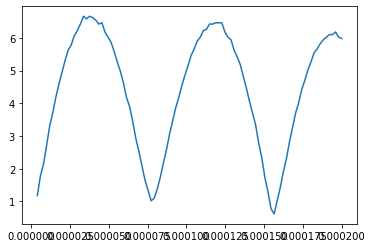

In [13]:
min_t = .4e-6
max_t = 20e-6
num = 100
arr = np.linspace(min_t,max_t,num)
delay_time = 2

amps = []

# print(arr)
for t in arr:
    rabi_pulse(t)
    x,y = trace(delay_time)
    amp = np.max(y)
    amps.append(amp)
    print(f"Pulse Time {t*1e6}us, max is {amp}")

plt.plot(arr*10,amps)


In [67]:
f = open('data_rabi_3_28.txt', 'w')
for i in range(len(arr)):
    f.write(arr[i])
    f.write(',')
    f.write(amps[i])
    f.write('\n')
f.close()

TypeError: write() argument must be str, not numpy.float64

In [65]:
#fit functions

def sinusoid(x, A, T, phase, offset):
    return A*np.cos((2*np.pi/T)*x + phase) + offset

def exp_decay(t, A, decay, offset):
    return A*np.exp(-t/decay) + offset

def exp_osc(x, A, decay, T,phase,offset):
    return np.e**(-x/decay)*(A*np.cos((2*np.pi/T)*x + phase)) + offset

def exp_osc_natalia(x, A, B, C, omega, offs1, offs2):
    return np.e**(-C*x)*(A*np.cos(omega*x)+B*np.sin(omega*x)+offs1+offs2)


In [34]:
amps[0]

1.18

In [39]:
print([exp_osc_natalia(a, 1, 1, 1, 1, 0, 0) for a in arr])

[0.9999999999998399, 0.9999999999996424, 0.9999999999993664, 0.9999999999990122, 0.9999999999985795, 0.9999999999980682, 0.9999999999974787, 0.9999999999968107, 0.9999999999960644, 0.9999999999952396, 0.9999999999943365, 0.999999999993355, 0.9999999999922952, 0.9999999999911569, 0.9999999999899403, 0.9999999999886452, 0.9999999999872717, 0.9999999999858199, 0.9999999999842898, 0.9999999999826812, 0.9999999999809939, 0.9999999999792285, 0.9999999999773848, 0.9999999999754626, 0.9999999999734619, 0.9999999999713829, 0.9999999999692256, 0.9999999999669898, 0.9999999999646758, 0.9999999999622833, 0.9999999999598123, 0.9999999999572631, 0.9999999999546352, 0.9999999999519292, 0.9999999999491447, 0.9999999999462816, 0.9999999999433404, 0.9999999999403207, 0.9999999999372229, 0.9999999999340462, 0.9999999999307914, 0.9999999999274582, 0.9999999999240466, 0.9999999999205564, 0.9999999999169881, 0.9999999999133414, 0.9999999999096162, 0.9999999999058126, 0.9999999999019307, 0.9999999998979703, 

[3.9999999999992104, 3.9999999999982356, 3.9999999999968736, 3.999999999995125, 3.999999999992989, 3.9999999999904667, 3.9999999999875575, 3.9999999999842615, 3.9999999999805786, 3.9999999999765086, 3.999999999972052, 3.9999999999672085, 3.999999999961978, 3.999999999956361, 3.999999999950357, 3.999999999943966, 3.9999999999371885, 3.9999999999300235, 3.9999999999224722, 3.9999999999145337, 3.999999999906209, 3.9999999998974967, 3.9999999998883977, 3.9999999998789124, 3.99999999986904, 3.99999999985878, 3.999999999848134, 3.999999999837101, 3.999999999825681, 3.999999999813874, 3.9999999998016804, 3.9999999997891003, 3.999999999776133, 3.9999999997627786, 3.9999999997490376, 3.99999999973491, 3.9999999997203948, 3.9999999997054934, 3.9999999996902047, 3.9999999996745297, 3.9999999996584674, 3.9999999996420184, 3.9999999996251825, 3.99999999960796, 3.9999999995903504, 3.999999999572354, 3.999999999553971, 3.9999999995352007, 3.999999999516044, 3.9999999994965, 3.9999999994765694, 3.9999

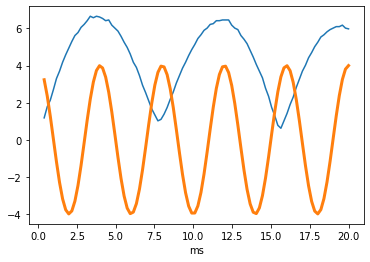

In [66]:
fit, err = curve_fit(sinusoid, arr, amps, p0 = [4, 4, 0, 0])
plt.plot(arr*1e6, amps)
plt.xlabel('ms')
#plt.plot(arr, sinusoid(arr, *(4, 4, 0, 4)), linewidth = 3)
plt.plot(arr*1e6, sinusoid(arr*1e6, *fit), linewidth = 3)
print([sinusoid(a, *fit) for a in arr])
print(arr)
plt.show()

In [19]:
T2_star = fit[1]
T2_star_err = np.sqrt(err[1,1])
print('T2* time: %.2f +- %.1e ms' % (T2_star, T2_star_err))

T2* time: 726251712.30 +- inf ms


In [53]:
#T1 Experiment

def t1_exp(pi2_pulse, pi_pulse, tau):
    pi2_pulse_samples = pi2_pulse * SAMPLE_RATE
    pi_pulse_samples = pi_pulse * SAMPLE_RATE

    delay_nums = 50
    delay_unit = tau / delay_nums
    delay_unit_samples = int(delay_unit * SAMPLE_RATE)

    awg.write("SOUR1:DATA:VOL:CLE")

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_2_PULSE, ', 
        np.ones(int(pi2_pulse_samples), dtype=int) * MAX, 
        datatype='i')
    
    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC DELAY, ', 
        np.zeros(int(delay_unit_samples), dtype=int), 
        datatype='i')

    awg.write_binary_values(
        'SOUR1:DATA:ARB:DAC PI_PULSE, ', 
        np.ones(int(pi_pulse_samples), dtype=int) * MAX, 
        datatype='i')
    
    sequence_command = f'T1,PI_PULSE,0,once,highAtStart,0,DELAY,{delay_nums},repeat,lowAtStart,0,PI_2_PULSE,0,once,highAtStart,0,DELAY,0,onceWaitTring,lowAtStart,0'

    sequence_length = len(sequence_command.encode('ascii'))
    full_sequence_command = f"SOUR1:DATA:SEQ #{len(str(sequence_length))}{sequence_length}" + sequence_command
    awg.write(full_sequence_command)

    AMPLITUDE = 3 # real voltage
    awg.write('SOUR1:FUNC:ARB T1')
    awg.write(f'SOUR1:VOLT {AMPLITUDE}')
    awg.write('OUTP1 ON')




In [54]:
pi_pulse_time = 8e-6
pi_2_pulse_time = 4e-6
tau = 300e-3
t1_exp(pi_2_pulse_time, pi_pulse_time, tau)
trace(1)

(array([-0.005    , -0.0049999, -0.0049998, ...,  0.0049997,  0.0049998,
         0.0049999]),
 array([0.698, 0.698, 0.698, ..., 0.698, 0.698, 0.698]))

The above example should be readily applicable to the Hahn Echo sequence. Writing other pulse sequeces such as Rabi, T1, and CPMG. To change the phase, for XY-N pulses, one can modify the pulse amplitude at the start of the pulse to reflect the chosen phase. Here, we use np.ones to set the pulse shape to square, but you'll need to adjust that to reflect the 90 degree phase shift between the two pulses

Another somewhat simpler implementation for a single pulse sequeunce is below:

In [12]:
def PULSE_A():
    waveform = np.pad(np.ones(PULSE_A_SAMPLES).astype(int) * MAX, pad_width=(0, 50))
    
    awg.write('SOUR1:DATA:VOL:CLE')

    awg.write_binary_values('SOUR1:DATA:ARB:DAC PULSE_A, ', waveform, datatype='i')
    
    awg.write('SOUR1:FUNC:ARB PULSE_A')
    awg.write('SOUR1:VOLT 4')
    awg.write('OUTP1 ON')

Also useful to be able to communicate with the scope to extract information from it. 
A simple way to get a value from the scope is below, where you are using the measurement functionality of the scope. Important would be set the correct point for the scope to measure, since the position of echo depends on precession time, pulse number, etc, from the last trigger.

In [17]:
scope.write('MEASUrement:MEAS1:STATE ON')

time.sleep(1) #Time the scope is in the measurement state, in units of seconds.

mean = float(scope.query('MEASUrement:MEAS1:MEAN?'))
count = int(scope.query('MEASUrement:MEAS1:COUNt?'))
std = float(scope.query('MEASUrement:MEAS1:STDdev?'))

scope.write('MEASUrement:MEAS1:STATE OFF')

#return mean, count, std
print(mean, count, std)

1.8285 2677 0.0923579


Perhaps more easily, you can also extract all the whole oscilloscope trace. Note that you will need to trigger the oscillscope to properly extract the trace containining your data, this can be contained within the AWG sequence command.  You can then analyze those traces yourself. 

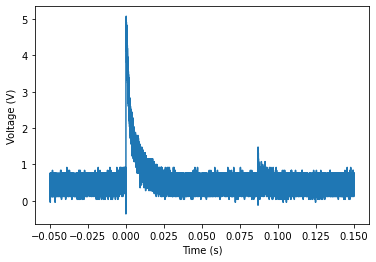

(array([-0.05    , -0.049998, -0.049996, ...,  0.149994,  0.149996,
         0.149998]),
 array([0.6 , 0.04, 0.36, ..., 0.36, 0.44, 0.44]))

In [73]:
trace(1)
